In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
#reload modules
%load_ext autoreload
%autoreload 2

In [4]:
import join_data as jd

In [5]:
from helpers import *

In [6]:
filesavelabel = 'reportfeaturesonly_'

# Load and join the public data

In [7]:
mergeddf = jd.pipeline(directory = '../data/', FSfilename = 'FSR_221022.csv', FIfilename = 'FI_221022.csv', FWOfilename = 'FWO_221022.csv', FRAfilename = 'FRA_221024.csv')

### Load + join model estimates for reporting delays

In [8]:
predicted_delays_filename = './data_est_report_delays/reports_delay_20230605_projected.csv'

In [9]:
# Load in reporting delays from the model predictions
predicted_report_delays = pd.read_csv(predicted_delays_filename)
predicted_report_delays = predicted_report_delays.rename(columns={'Delay': 'reporting_delay', 'BoroughCode': 'Borough'})
predicted_report_delays.head()

,OBJECTID,Borough,SRCategory,reporting_delay
0,17450683,Bronx,Hazard,5.615999
1,23493187,Bronx,Hazard,5.615999
2,17508680,Bronx,Hazard,5.615999
3,24373423,Bronx,Hazard,5.615999
4,5644373,Bronx,Hazard,5.615999


In [10]:
predicted_report_delays[['Borough', 'SRCategory', 'reporting_delay']].drop_duplicates()

,Borough,SRCategory,reporting_delay
0,Bronx,Hazard,5.615999
24239,Bronx,Illegal Tree Damage,24.009376
27436,Bronx,Prune,50.798478
40093,Bronx,Remove Tree,35.242752
49387,Bronx,Root/Sewer/Sidewalk,179.165400
57824,Brooklyn,Hazard,10.233688
134778,Brooklyn,Illegal Tree Damage,43.446078
144658,Brooklyn,Prune,36.121166
188470,Brooklyn,Remove Tree,37.092489
215122,Brooklyn,Root/Sewer/Sidewalk,207.218543


## Merge report delays with rest of public data

In [11]:
mergeddf = pd.merge(mergeddf, predicted_report_delays[['Borough', 'SRCategory', 'reporting_delay']].drop_duplicates(), on=['Borough', 'SRCategory'], how='left')

In [12]:
mergeddf.groupby('SRCategory')[["IncidentGlobalID", "reporting_delay"]].count()

,IncidentGlobalID,reporting_delay
SRCategory,,
Claims,121,0
Hazard,280239,280165
Illegal Tree Damage,32394,32360
Pest/Disease,215,0
Plant Tree,146018,0
Planting Space,65,0
Prune,141373,141317
Remove Debris,1091,0
Remove Stump,1667,0


In [13]:
# drop the other categories, only doing the main categories
mergeddf = mergeddf[mergeddf.reporting_delay.notna()]

# Delay analysis final data preparation

First, combine multiple reports of the same incident so that I have one row per unique incident. Take first inspection and report date as the right date.

In [ ]:
wofinishdatecolumn = 'ActualFinishDate' # 'WOClosedDate'


In [14]:
nodups = mergeddf[['IncidentGlobalID','SRCategory','SRCreatedDate', 'InspectionDate',wofinishdatecolumn,'Risk_coded','Borough','reporting_delay']].groupby('IncidentGlobalID').agg(
    {'SRCreatedDate': 'min', 'InspectionDate': 'min', wofinishdatecolumn: 'min', 'SRCategory': 'first', 'Risk_coded': 'first', 'Borough': 'first', 'reporting_delay':'first'}).reset_index()
nodups['inspection_delay'] = (nodups['InspectionDate'] - nodups['SRCreatedDate']).dt.total_seconds() / 3600 /24
nodups['work_delay'] = (nodups[wofinishdatecolumn] - nodups['InspectionDate']).dt.total_seconds() / 3600 /24

In [15]:
nodups_rightdate = nodups[(nodups['SRCreatedDate'] >= '2017-06-30') & (nodups['SRCreatedDate'] < '2020-07-01')]

In [16]:
nodups_rightdate[['SRCreatedDate','InspectionDate', wofinishdatecolumn]].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,WOClosedDate
count,169881,109232,53240
mean,2018-12-01 07:45:13.899070208,2019-01-01 14:32:55.684991488,2019-05-24 04:35:11.452160
min,2017-06-30 00:02:43,1900-01-01 00:00:00,2015-04-07 15:13:00
25%,2018-03-30 13:14:35,2018-04-14 04:00:00,2018-07-26 14:12:45
50%,2018-10-26 13:30:25,2018-11-16 14:45:30.500000,2019-04-15 19:14:30
75%,2019-08-09 16:33:00,2019-09-11 07:28:48.750000128,2020-02-20 12:44:30
max,2020-06-30 23:46:32,2022-08-25 16:04:55,2022-08-31 18:07:00


<Axes: >

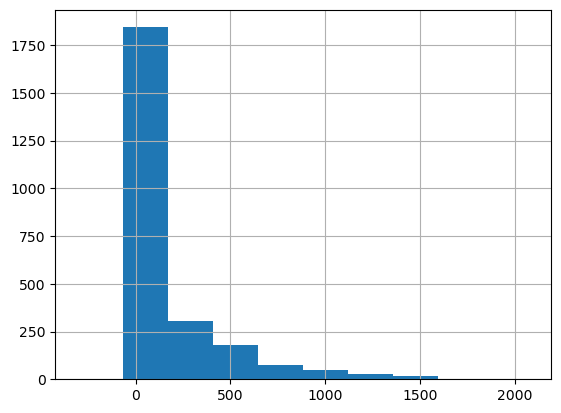

In [17]:
nodups_rightdate.query('Borough == "Bronx" and SRCategory == "Hazard"').work_delay.hist()

In [18]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['work_delay'].median()

SRCategory           Borough      
Hazard               Bronx             19.935243
                     Brooklyn          17.397917
                     Manhattan          5.122257
                     Queens             7.267743
                     Staten Island     13.047147
Illegal Tree Damage  Bronx            178.062766
                     Brooklyn         141.326435
                     Manhattan         20.597569
                     Queens            83.216366
                     Staten Island    105.507639
Prune                Bronx             77.904896
                     Brooklyn         124.250451
                     Manhattan        130.153235
                     Queens            57.416956
                     Staten Island     70.083310
Remove Tree          Bronx            212.153698
                     Brooklyn         144.252674
                     Manhattan         78.592361
                     Queens           125.385064
                     Staten Island

In [19]:
nodups_rightdate.groupby(['Risk_coded', 'Borough'])['work_delay'].count()

Risk_coded  Borough      
A           Bronx              157
            Brooklyn           129
            Manhattan          216
            Queens            2191
            Staten Island      133
B           Bronx              558
            Brooklyn           392
            Manhattan          451
            Queens            2943
            Staten Island      425
C           Bronx              824
            Brooklyn          1631
            Manhattan          843
            Queens            4039
            Staten Island      934
D           Bronx             2701
            Brooklyn         10398
            Manhattan         3544
            Queens           12132
            Staten Island     3959
E           Bronx                2
            Brooklyn             0
            Queens               7
Unknown     Bronx              607
            Brooklyn           740
            Manhattan          282
            Queens            2094
            Staten Island    

In [20]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['work_delay'].count()

SRCategory           Borough      
Hazard               Bronx             2500
                     Brooklyn          7539
                     Manhattan         2609
                     Queens           13472
                     Staten Island     2882
Illegal Tree Damage  Bronx              134
                     Brooklyn           384
                     Manhattan          334
                     Queens             363
                     Staten Island       95
Prune                Bronx              551
                     Brooklyn          1029
                     Manhattan          936
                     Queens            1526
                     Staten Island      883
Remove Tree          Bronx             1298
                     Brooklyn          3391
                     Manhattan         1417
                     Queens            6364
                     Staten Island     1902
Root/Sewer/Sidewalk  Bronx              366
                     Brooklyn           9

In [21]:
nodups_rightdate.groupby(['Risk_coded', 'Borough'])['work_delay'].median()

Risk_coded  Borough      
A           Bronx             15.969259
            Brooklyn           5.016273
            Manhattan          5.242465
            Queens             6.633333
            Staten Island      8.834097
B           Bronx             38.265718
            Brooklyn           7.333524
            Manhattan          6.309028
            Queens             6.266887
            Staten Island     24.991609
C           Bronx            145.524468
            Brooklyn          69.962025
            Manhattan         11.397917
            Queens            84.444352
            Staten Island    125.491233
D           Bronx            161.925324
            Brooklyn          64.614931
            Manhattan         35.525556
            Queens            76.808437
            Staten Island    130.180521
E           Bronx            118.201736
            Brooklyn                NaN
            Queens           895.154317
Unknown     Bronx             22.620139
            Br

In [22]:
nodups_rightdate.count()

IncidentGlobalID    169881
SRCreatedDate       169881
InspectionDate      109232
WOClosedDate         53240
SRCategory          169881
Risk_coded          169881
Borough             169881
reporting_delay     169881
inspection_delay    109232
work_delay           53238
dtype: int64

In [23]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()

/tmp/ipykernel_14639/2028202929.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()


reporting_delay  inspection_delay  \
SRCategory          Borough                                            
Hazard              Bronx                 5.615999          1.958171   
                    Brooklyn             10.233688          3.949248   
                    Manhattan             2.800903          0.484097   
                    Queens                7.413932          1.853831   
                    Staten Island         5.310541          1.500833   
Illegal Tree Damage Bronx                24.009376          8.875058   
                    Brooklyn             43.446078         37.026412   
                    Manhattan            15.529353          4.347917   
                    Queens               32.073806         25.801186   
                    Staten Island         7.597800          3.852153   
Prune               Bronx                50.798478         13.079861   
                    Brooklyn             36.121166         10.865804   
                    Manhattan            90.206276          5.618750   
                    Queens               48.576555          8.895295   
                    Staten Island        16.054043          3.242245   
Remove Tree         Bronx                35.242752          6.812257   
                    Brooklyn             37.092489         13.945972   
                    Manhattan            50.900487          3.440972   
                    Queens               32.290385          6.904630   
                    Staten Island        17.791560          4.481308   
Root/Sewer/Sidewalk Bronx               179.165400         18.884167   
                    Brooklyn            207.218543         20.886366   
                    Manhattan           280.104291         15.874965   
                    Queens              246.408395         18.859514   
                    Staten Island       222.529505         20.829329   

                                   work_delay  
SRCategory          Borough                    
Hazard              Bronx           19.935243  
                    Brooklyn        17.397917  
                    Manhattan        5.122257  
                    Queens           7.267743  
                    Staten Island   13.047147  
Illegal Tree Damage Bronx          178.062766  
                    Brooklyn       141.326435  
                    Manhattan       20.597569  
                    Queens          83.216366  
                    Staten Island  105.507639  
Prune               Bronx           77.904896  
                    Brooklyn       124.250451  
                    Manhattan      130.153235  
                    Queens          57.416956  
                    Staten Island   70.083310  
Remove Tree         Bronx          212.153698  
                    Brooklyn       144.252674  
                    Manhattan       78.592361  
                    Queens         125.385064  
                    Staten Island  164.233212  
Root/Sewer/Sidewalk Bronx          561.174635  
                    Brooklyn       652.977789  
                    Manhattan      275.303403  
                    Queens         663.898646  
                    Staten Island  764.016921

In [24]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x)))

/tmp/ipykernel_14639/2923335990.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x)))


reporting_delay  inspection_delay  \
SRCategory          Borough                                            
Hazard              Bronx                      1.0          0.749224   
                    Brooklyn                   1.0          0.831558   
                    Manhattan                  1.0          0.557777   
                    Queens                     1.0          0.800623   
                    Staten Island              1.0          0.522394   
Illegal Tree Damage Bronx                      1.0          0.700957   
                    Brooklyn                   1.0          0.871748   
                    Manhattan                  1.0          0.404839   
                    Queens                     1.0          0.631371   
                    Staten Island              1.0          0.360054   
Prune               Bronx                      1.0          0.833172   
                    Brooklyn                   1.0          0.313990   
                    Manhattan                  1.0          0.715858   
                    Queens                     1.0          0.233502   
                    Staten Island              1.0          0.275187   
Remove Tree         Bronx                      1.0          0.853873   
                    Brooklyn                   1.0          0.910004   
                    Manhattan                  1.0          0.511105   
                    Queens                     1.0          0.816349   
                    Staten Island              1.0          0.700913   
Root/Sewer/Sidewalk Bronx                      1.0          0.597052   
                    Brooklyn                   1.0          0.600651   
                    Manhattan                  1.0          0.181149   
                    Queens                     1.0          0.645243   
                    Staten Island              1.0          0.655092   

                                   work_delay  
SRCategory          Borough                    
Hazard              Bronx            0.430886  
                    Brooklyn         0.422590  
                    Manhattan        0.501634  
                    Queens           0.511718  
                    Staten Island    0.377423  
Illegal Tree Damage Bronx            0.160287  
                    Brooklyn         0.117539  
                    Manhattan        0.179570  
                    Queens           0.143422  
                    Staten Island    0.129076  
Prune               Bronx            0.133028  
                    Brooklyn         0.119665  
                    Manhattan        0.468234  
                    Queens           0.084839  
                    Staten Island    0.169449  
Remove Tree         Bronx            0.457042  
                    Brooklyn         0.466630  
                    Manhattan        0.374669  
                    Queens           0.412550  
                    Staten Island    0.445121  
Root/Sewer/Sidewalk Bronx            0.128466  
                    Brooklyn         0.134060  
                    Manhattan        0.058910  
                    Queens           0.146992  
                    Staten Island    0.138662

In [25]:
addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed.head()

/tmp/ipykernel_14639/2333777964.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,SRCategory,Borough,reporting_delay,inspection_delay,work_delay
0,Hazard,Bronx,1.0,0.749224,0.430886
1,Hazard,Brooklyn,1.0,0.831558,0.422590
2,Hazard,Manhattan,1.0,0.557777,0.501634
3,Hazard,Queens,1.0,0.800623,0.511718
4,Hazard,Staten Island,1.0,0.522394,0.377423


In [26]:
#turn inpsection and work delays into rows instead of columns
addressed = addressed.melt(id_vars=['SRCategory', 'Borough'], value_vars=['reporting_delay', 'inspection_delay', 'work_delay'], var_name='delay_type', value_name='percent_addressed')

addressed = addressed.rename({'percent_addressed': 'Fraction addressed', 'delay_type': 'Action'}, axis=1)

addressed.loc[:, 'Action'] = addressed.loc[:, 'Action'].str.replace('inspection_delay', 'Inspection').str.replace('work_delay', 'Work order')

addressed

,SRCategory,Borough,Action,Fraction addressed
0,Hazard,Bronx,reporting_delay,1.000000
1,Hazard,Brooklyn,reporting_delay,1.000000
2,Hazard,Manhattan,reporting_delay,1.000000
3,Hazard,Queens,reporting_delay,1.000000
4,Hazard,Staten Island,reporting_delay,1.000000
...,...,...,...,...
70,Root/Sewer/Sidewalk,Bronx,Work order,0.128466
71,Root/Sewer/Sidewalk,Brooklyn,Work order,0.134060
72,Root/Sewer/Sidewalk,Manhattan,Work order,0.058910
73,Root/Sewer/Sidewalk,Queens,Work order,0.146992


# Plotting

## What fraction of incidents are actually addressed

Hazard
Illegal Tree Damage
Prune
Remove Tree
Root/Sewer/Sidewalk


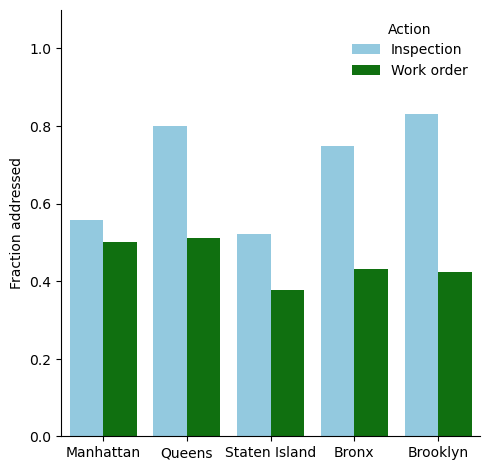

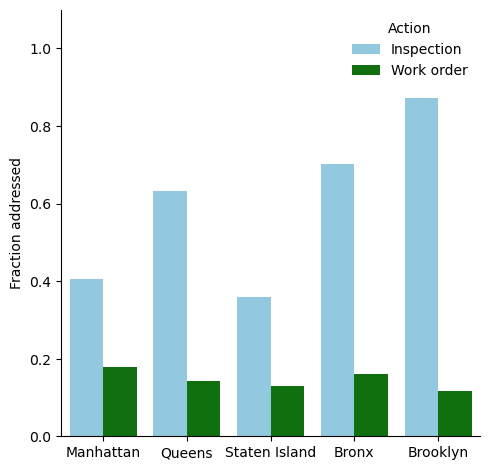

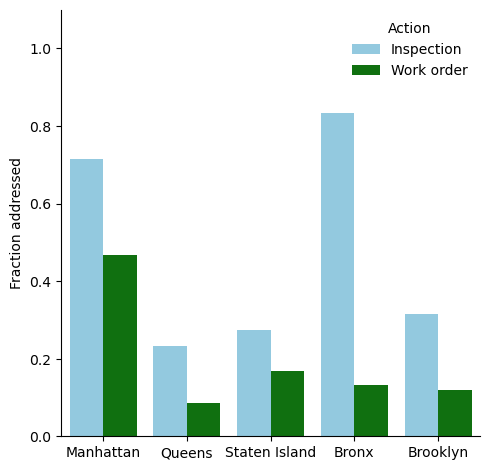

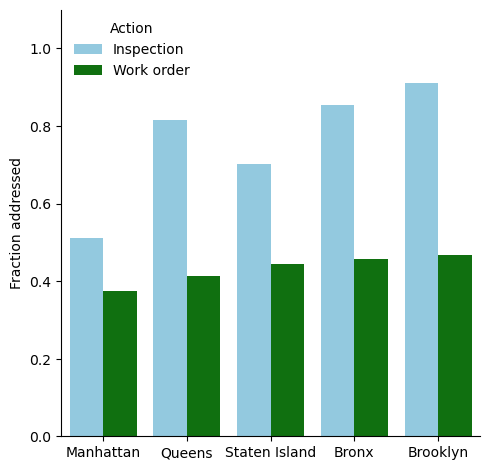

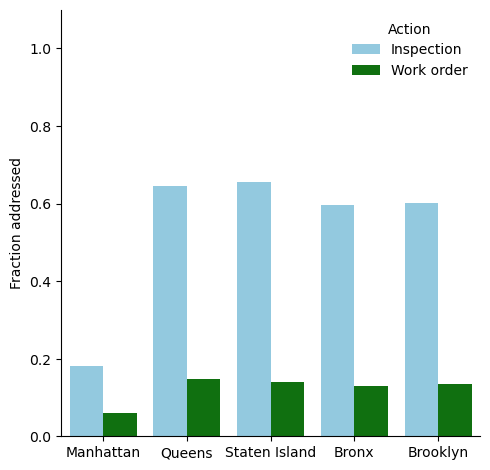

In [28]:
for cat in addressed.SRCategory.unique():
    print(cat)

    plot = sns.catplot(
        data=addressed.query('SRCategory == @cat and Action!="reporting_delay"'), kind="bar",
        x="Borough", y="Fraction addressed", hue="Action",
        errorbar="sd", palette= ['skyblue', 'green'], legend_out = False, #, alpha=.6, height=6
        order = ['Manhattan', 'Queens', 'Staten Island', 'Bronx', 'Brooklyn']
    )
    legend = plot._legend
    legend.set_frame_on(False)
    plt.ylim(0, 1.1)
    plt.xlabel(None)
    catsave = cat.replace('/', '')
    plt.savefig(f'plots/{filesavelabel}{catsave}_fractionaddressed.pdf', bbox_inches='tight')

## Delays conditional on addressed

Overall split by typecol but not other group


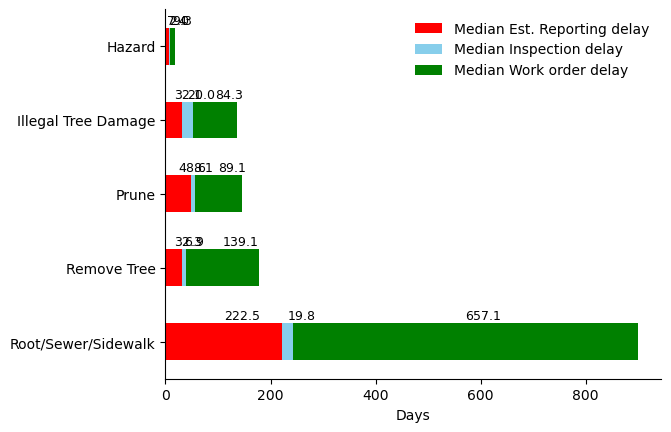

Hazard


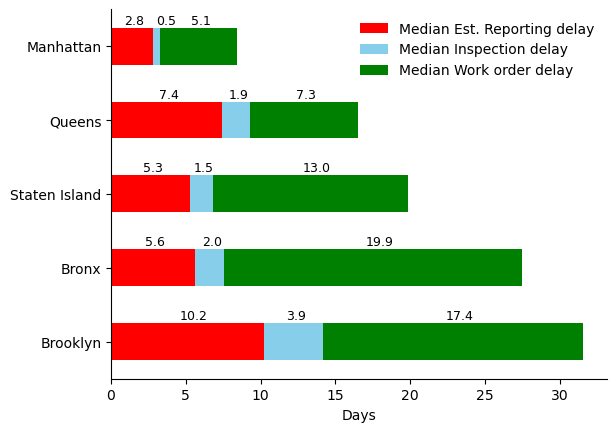

Remove Tree


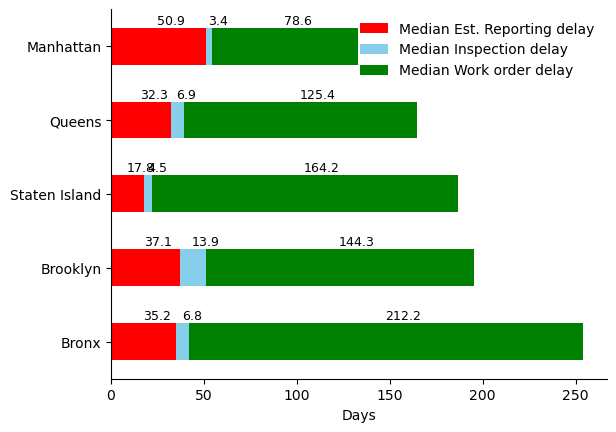

Root/Sewer/Sidewalk


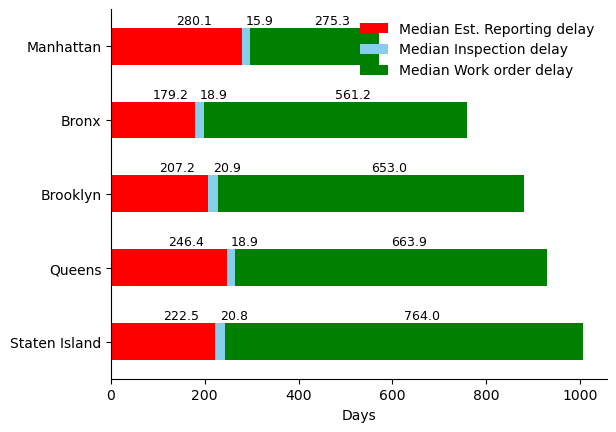

Prune


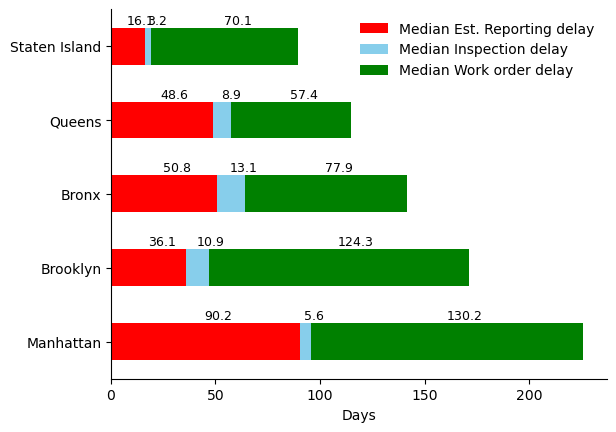

Illegal Tree Damage


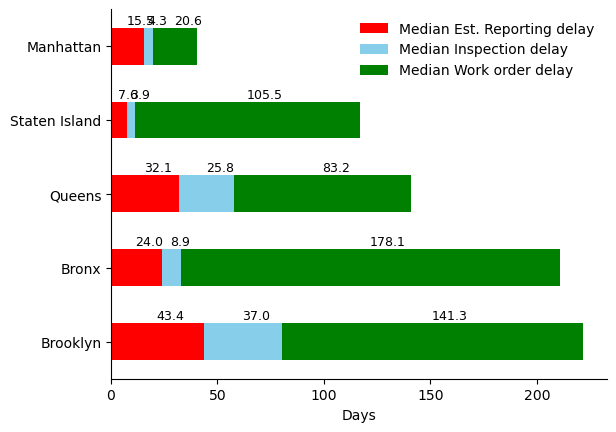

In [27]:
plot_bar_by_type(nodups_rightdate, typecol = 'SRCategory', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}')

In [28]:
# nodups_rightdate = nodups_rightdate.sort_values(by = 'Risk_coded', ascending = True)

In [29]:
# plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'Risk_coded', othergroupby = 'Borough', impute_missing_work_order = False)

In [30]:
# plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'Risk_coded', othergroupby = 'Borough', do_inspection_correction = False, do_work_delay = True, impute_missing_work_order = True)